In [1]:
import xarray as xr
import os
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [2]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)


FOR DOWNSCALED ERA5
-

In [3]:
start_winter_year=2021
number_of_seasons=1

In [4]:
def load_Xyrs_winter_dataset(start_winter_year, X):
    print("Loading multi-year winter dataset...")
    months_first_year = ['11', '12']  # Nov, Dec
    months_second_year = ['01', '02', '03']  # Jan–Mar
    vars_to_keep = ['SNOW', 'acsnow', 'rainnc', 'XLAT', 'XLONG']
    all_file_list = []
    for i in range(X):
        year1 = start_winter_year + i
        year2 = year1 + 1
        path1 = f'/import/beegfs/CMIP6/wrf_era5/04km/{year1}'
        path2 = f'/import/beegfs/CMIP6/wrf_era5/04km/{year2}'
        for month in months_first_year:
            pattern = f"era5_wrf_dscale_4km_{year1}-{month}-*.nc"
            all_file_list += sorted(glob.glob(os.path.join(path1, pattern))) or \
                             print(f"{year1}-{month}: ERROR No files found")
        for month in months_second_year:
            pattern = f"era5_wrf_dscale_4km_{year2}-{month}-*.nc"
            all_file_list += sorted(glob.glob(os.path.join(path2, pattern))) or \
                             print(f"{year2}-{month}: ERROR No files found")
    def preprocess(ds):
        os.chdir("/import/beegfs/CMIP6/wrf_era5")
        geo_em_path = "geo_em.d02.nc"   
        geo = xr.open_dataset(geo_em_path)
        oceanmask=geo['LU_INDEX']
        oceanmask=oceanmask.squeeze(dim='Time')

        ds = ds.where(oceanmask != 17)
        return ds[['SNOW', 'acsnow', 'rainnc']]
    if not all_file_list:
        raise ValueError("No files found across the X-year winter period!")
    data = xr.open_mfdataset(
    all_file_list,
    combine='by_coords',
    engine='netcdf4',
    preprocess=preprocess,
    parallel=True,)
    return data

In [5]:
dscaled_ds = load_Xyrs_winter_dataset(start_winter_year, number_of_seasons)

Loading multi-year winter dataset...


In [6]:
dscaled_SNOW=dscaled_ds['SNOW']
dscaled_RAIN=dscaled_ds['rainnc']-dscaled_ds['acsnow']
dscaled_SF=dscaled_ds['acsnow']

In [7]:
dscaledtotal_hours = dscaled_RAIN.shape[0]

RAINcriteriacount = np.sum(dscaled_RAIN > 0.254, axis=0)
percentRAIN_MET= (RAINcriteriacount / dscaledtotal_hours) * 100

SFcriteriacount=np.sum(dscaled_SF, axis=0)
percentSF_MET= (SFcriteriacount / dscaledtotal_hours) * 100

SNOWcriteriacount = np.sum(dscaled_SNOW > 2.54, axis=0)
percentSNOW_MET = (SNOWcriteriacount / dscaledtotal_hours) * 100


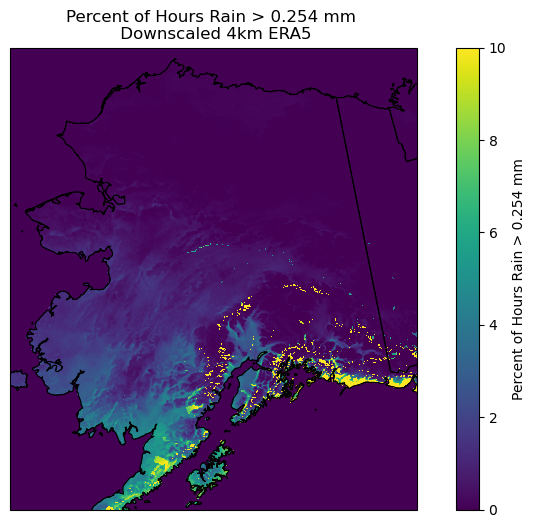

In [8]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))} 
plt.figure(figsize=(10,6))
ax = plt.axes(**AK_ALBERS_SUBPLOT_KW)

plt.pcolormesh(percentRAIN_MET['XLONG'], 
               percentRAIN_MET['XLAT'], 
               percentRAIN_MET, 
               shading='auto', 
               cmap='viridis',
               vmin=0,
               vmax=10,
               transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.8, edgecolor='black')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)

plt.colorbar(label='Percent of Hours Rain > 0.254 mm', ax=ax)
ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Percent of Hours Rain > 0.254 mm \n Downscaled 4km ERA5')
plt.show()

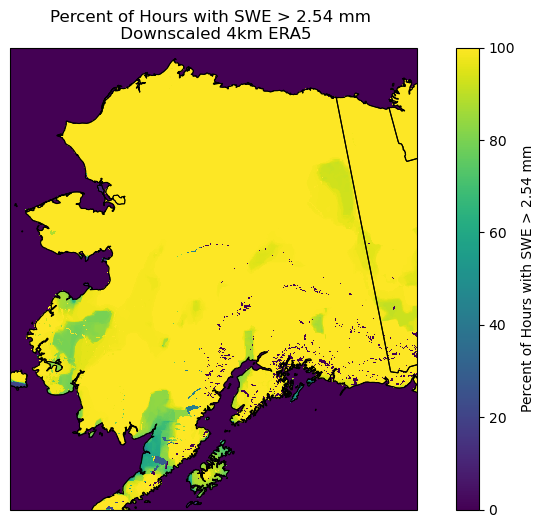

In [9]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))} 
plt.figure(figsize=(10,6))
ax = plt.axes(**AK_ALBERS_SUBPLOT_KW)

plt.pcolormesh(percentSNOW_MET['XLONG'], 
               percentSNOW_MET['XLAT'], 
               percentSNOW_MET, 
               shading='auto', 
               cmap='viridis',
               vmin=0,
               vmax=100,
               transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.8, edgecolor='black')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)

plt.colorbar(label='Percent of Hours with SWE > 2.54 mm', ax=ax)
ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Percent of Hours with SWE > 2.54 mm \n Downscaled 4km ERA5')
plt.show()

In [10]:
fairbanks_lat = 64.84
fairbanks_lon = -147.72

lat = dscaled_SNOW.XLAT.compute().values
lon = dscaled_SNOW.XLONG.compute().values
dist = np.sqrt((lat - fairbanks_lat)**2 + (lon - fairbanks_lon)**2)
# Get the nearest grid point
diy, dix = np.unravel_index(np.argmin(dist), dist.shape)
print(f"Nearest grid point indices: south_north={diy}, west_east={dix}")
dscale_snow_fairbanks = dscaled_SNOW.isel(south_north=diy, west_east=dix)
dscale_rain_fairbanks= dscaled_RAIN.isel(south_north=diy, west_east=dix)
dscale_sf_fairbanks= dscaled_SF.isel(south_north=diy, west_east=dix)
#Check point  
dlat_sel = float(dscaled_SNOW.XLAT[diy, dix].values)
dlon_sel = float(dscaled_SNOW.XLONG[diy,dix].values)
print(f"Nearest grid point lat/lon: {lat_sel:.4f}, {lon_sel:.4f}")

Nearest grid point indices: south_north=252, west_east=263


NameError: name 'lat_sel' is not defined

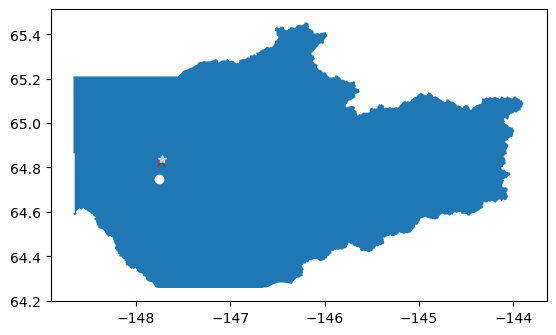

In [63]:
ax = FNSB_boundary.plot() 
ax.plot(dlon_sel, dlat_sel, marker='x', color='red')
ax.plot(lon_sel,lat_sel,marker='o',color='white')
ax.plot(fairbanks_lon,fairbanks_lat,color='lightblue',marker='*')
plt.show()

Raw ERA 5 here
- 


In [29]:
start_winter_year=2021
number_of_seasons=1

os.chdir("/import/beegfs/CMIP6/wrf_era5")
geo_em_path = "geo_em.d02.nc"
geo = xr.open_dataset(geo_em_path)

def crop_data (datatocrop , geodata):
    lat_geo = geodata['XLAT_M'].values
    lon_geo = geodata['XLONG_M'].values
    geo_lat_min = lat_geo.min()
    geo_lat_max = lat_geo.max()
    geo_lon_min = lon_geo.min()
    geo_lon_max = lon_geo.max()
    if datatocrop.longitude.max() > 180:
        datatocrop = datatocrop.assign_coords(longitude=(((datatocrop.longitude + 180) % 360) - 180))
        datatocrop = datatocrop.sortby('longitude')
    final_data= datatocrop.where((datatocrop.latitude >= geo_lat_min) & (datatocrop.latitude <= geo_lat_max) &(datatocrop.longitude >= geo_lon_min) & (datatocrop.longitude <= geo_lon_max),drop=True)
    
    return (final_data)
varlist=['tp','sf','sd']
os.chdir("/import/AKCASC/data/cds/reanalysis-era5-single-levels/")
data=xr.Dataset()
for i in range(number_of_seasons):
    year1=start_winter_year+i
    year2=year1+1
    print(year1,year2)
    months_first_year=['11','12']
    months_second_year=['01','02','03']  
    for var in varlist:
        all_months_data=[]
        for month in months_first_year:
            name='reanalysis-era5-single-levels_'
            year1_file=f'_{year1}_{month}.nc'
            #ds=xr.open_dataset(var+'/'+name+var+year1_file)
            with xr.open_dataset(var+'/'+name+var+year1_file) as varDS:
                try:
                    varDS = varDS.rename({'valid_time':'time'})  # if the time variable is named valid_time, rename it to time
                    print('changed from valid_time to time')
                except ValueError:
                    pass
            varDS = varDS.drop_vars(['expver', 'number'], errors='ignore')
            da=varDS[var]
            da_cropped=crop_data(da,geo)    
            all_months_data.append(da_cropped)
        for month in months_second_year:
            name='reanalysis-era5-single-levels_'
            year2_file=f'_{year2}_{month}.nc'
            #ds=xr.open_dataset(var+'/'+name+var+year2_file)
            with xr.open_dataset(var+'/'+name+var+year2_file) as varDS:
                try:
                    varDS = varDS.rename({'valid_time':'time'})  # if the time variable is named valid_time, rename it to time
                except ValueError:
                    pass
            varDS = varDS.drop_vars(['expver', 'number'], errors='ignore')
            da=varDS[var]
            da_cropped=crop_data(da,geo)    
            all_months_data.append(da_cropped)
        data[var]=xr.concat(all_months_data,dim='time',join='override',coords='minimal')

2021 2022


In [33]:
data['sf'] = data['sf'] * 1000
data['sf'].attrs['sf'] = 'mm'

data['tp'] = data['tp'] * 1000
data['tp'].attrs['units'] = 'mm'

data['RAIN']=(data['tp']-data['sf'])
data['RAIN'].attrs['units'] = 'mm'

data['sd']= data['sd']*1000
data['sd'].attrs['units'] = 'kg/m^-2'

In [34]:
raw_SNOW=data['sd']
raw_RAIN=data['RAIN']
raw_SF=data['sf']

In [16]:
fairbanks_lat = 64.84
fairbanks_lon = -147.72

lat = data.latitude.compute().values
lon = data.longitude.compute().values

lat2d, lon2d = np.meshgrid(lat, lon, indexing="ij")
dist = np.sqrt((lat2d - fairbanks_lat)**2 + (lon2d - fairbanks_lon)**2)
iy, ix = np.unravel_index(np.argmin(dist), dist.shape)
print(f"Nearest grid point indices: south_north={iy}, west_east={ix}")

raw_snow_fairbanks = raw_SNOW.isel(latitude=iy, longitude=ix)
raw_rain_fairbanks = raw_RAIN.isel(latitude=iy, longitude=ix)
raw_sf_fairbanks = raw_SF.isel(latitude=iy, longitude=ix)

lat_sel = float(raw_SNOW.latitude[iy].values)
lon_sel = float(raw_SNOW.longitude[ix].values)
print(f"Nearest grid point lat/lon: {lat_sel:.4f}, {lon_sel:.4f}")

Nearest grid point indices: south_north=29, west_east=113
Nearest grid point lat/lon: 64.7500, -147.7500


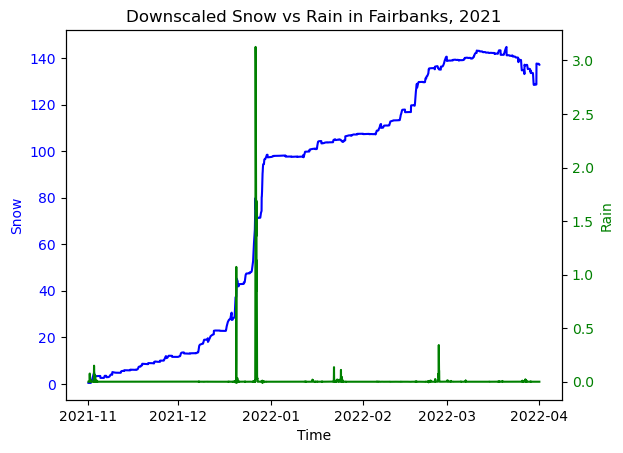

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(dscale_snow_fairbanks['Time'], dscale_snow_fairbanks, 'b', label='Snow')
ax1.set_xlabel('Time')
ax1.set_ylabel('Snow', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(dscale_rain_fairbanks['Time'], dscale_rain_fairbanks, 'g', label='Rain')
ax2.set_ylabel('Rain', color='g')
ax2.tick_params(axis='y', labelcolor='g')
plt.title('Downscaled Snow vs Rain in Fairbanks, 2021')
plt.show()


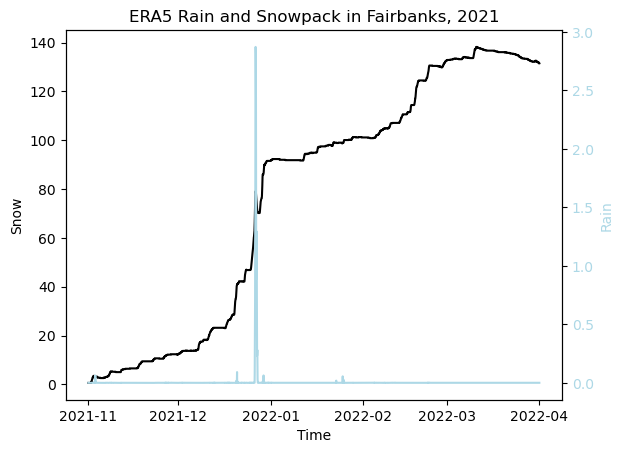

In [16]:
fig, ax1 = plt.subplots()

ax1.plot(raw_snow_fairbanks['time'], raw_snow_fairbanks, 'k', label='ERA5 Snow')
ax1.set_xlabel('Time')
ax1.set_ylabel('Snow', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax2 = ax1.twinx()

ax2.plot(raw_rain_fairbanks['time'], raw_rain_fairbanks, 'lightblue', label='ERA5 Rain')
ax2.set_ylabel('Rain', color='lightblue')
ax2.tick_params(axis='y', labelcolor='lightblue')

plt.title('ERA5 Rain and Snowpack in Fairbanks, 2021')
plt.show()

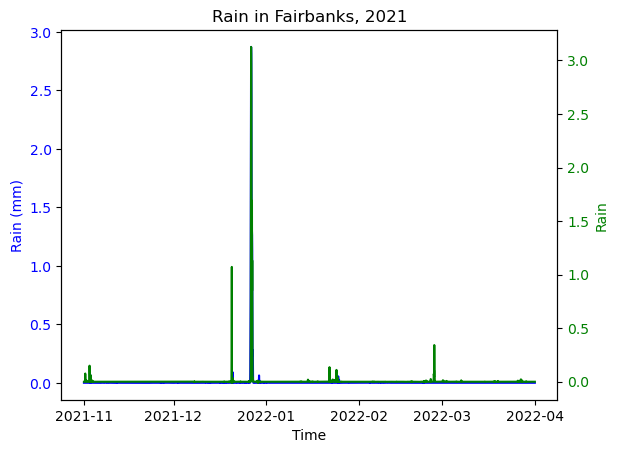

In [17]:
fig, ax1 = plt.subplots()
ax1.plot(raw_rain_fairbanks['time'], raw_rain_fairbanks, 'b', label='ERA5 Rain')
ax1.set_xlabel('Time')
ax1.set_ylabel('Rain (mm)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()

ax2.plot(dscale_rain_fairbanks['Time'], dscale_rain_fairbanks, 'g', label='Downscaled Rain')
ax2.set_ylabel('Rain', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('Rain in Fairbanks, 2021')
plt.show()

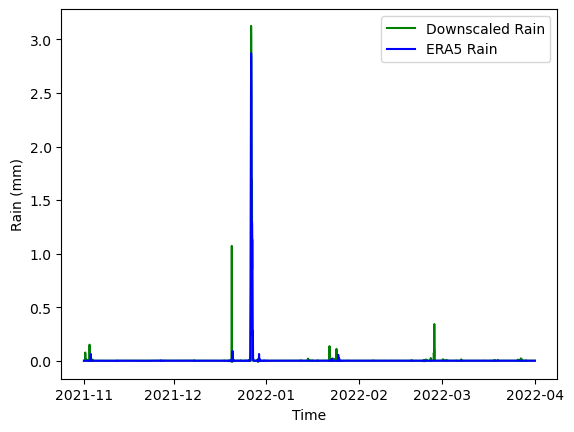

In [18]:
plt.figure()
plt.plot(dscale_rain_fairbanks['Time'], dscale_rain_fairbanks, 'g', label='Downscaled Rain')
plt.plot(raw_rain_fairbanks['time'], raw_rain_fairbanks, 'b', label='ERA5 Rain')
plt.xlabel('Time')
plt.ylabel('Rain (mm)')
plt.legend()
plt.show()

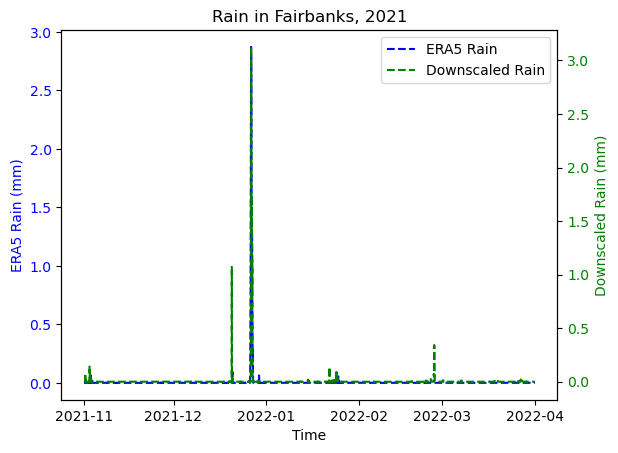

In [19]:
fig, ax1 = plt.subplots()
line1, = ax1.plot(raw_rain_fairbanks['time'], raw_rain_fairbanks, 'b--', label='ERA5 Rain')
ax1.set_xlabel('Time')
ax1.set_ylabel('ERA5 Rain (mm)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
line2, = ax2.plot(dscale_rain_fairbanks['Time'], dscale_rain_fairbanks, 'g--', label='Downscaled Rain')
ax2.set_ylabel('Downscaled Rain (mm)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Rain in Fairbanks, 2021')
plt.show()


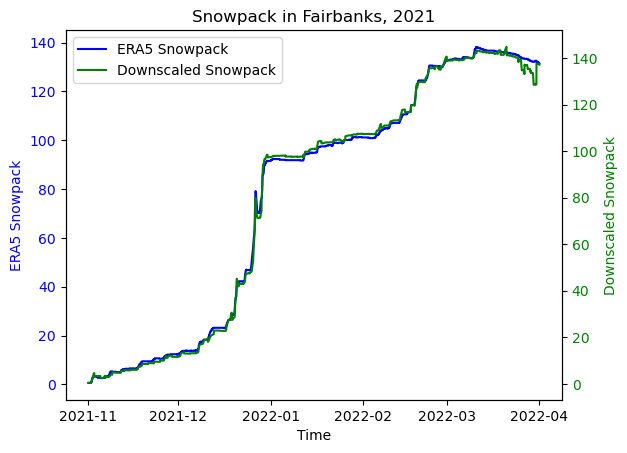

In [20]:
fig, ax1 = plt.subplots()
line1, = ax1.plot(raw_snow_fairbanks['time'], raw_snow_fairbanks, 'b', label='ERA5 Snowpack')
ax1.set_xlabel('Time')
ax1.set_ylabel('ERA5 Snowpack', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
line2, = ax2.plot(dscale_snow_fairbanks['Time'], dscale_snow_fairbanks, 'g', label='Downscaled Snowpack')
ax2.set_ylabel('Downscaled Snowpack', color='g')
ax2.tick_params(axis='y', labelcolor='g')
# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
plt.title('Snowpack in Fairbanks, 2021')
plt.show()

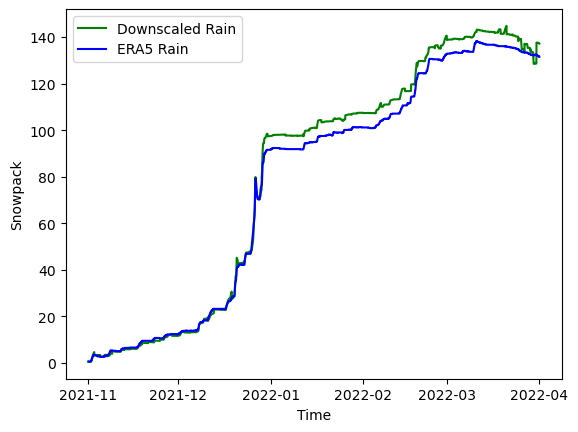

In [21]:
plt.figure()
plt.plot(dscale_snow_fairbanks['Time'], dscale_snow_fairbanks, 'g', label='Downscaled Rain')
plt.plot(raw_rain_fairbanks['time'], raw_snow_fairbanks, 'b', label='ERA5 Rain')
plt.xlabel('Time')
plt.ylabel('Snowpack')
plt.legend()
plt.show()

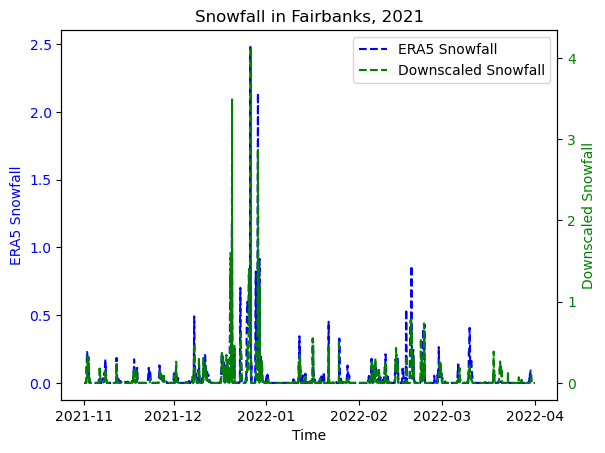

In [22]:
fig, ax1 = plt.subplots()
line1, = ax1.plot(raw_sf_fairbanks['time'], raw_sf_fairbanks, 'b--', label='ERA5 Snowfall')
ax1.set_xlabel('Time')
ax1.set_ylabel('ERA5 Snowfall', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
line2, = ax2.plot(dscale_sf_fairbanks['Time'], dscale_sf_fairbanks, 'g--', label='Downscaled Snowfall')
ax2.set_ylabel('Downscaled Snowfall', color='g')
ax2.tick_params(axis='y', labelcolor='g')
# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title('Snowfall in Fairbanks, 2021')
plt.show()

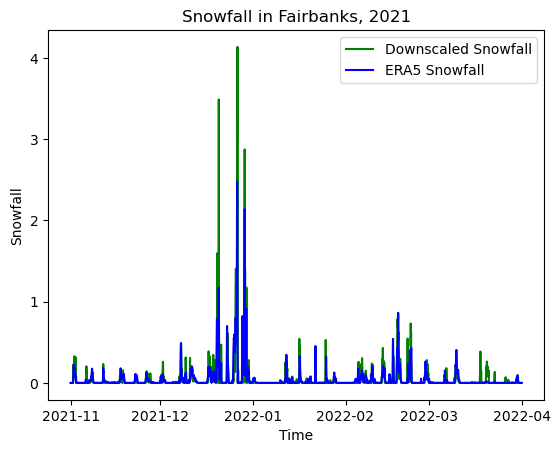

In [25]:
plt.plot(dscale_sf_fairbanks['Time'], dscale_sf_fairbanks, 'g', label='Downscaled Snowfall')
plt.plot(raw_sf_fairbanks['time'], raw_sf_fairbanks, 'b', label='ERA5 Snowfall')
plt.xlabel('Time')
plt.ylabel('Snowfall', color='k')
plt.legend(loc='upper right')
plt.title('Snowfall in Fairbanks, 2021')
plt.show()

In [44]:
percentSNOW_MET_Raw

<xarray.DataArray 'sd' (latitude: 68, longitude: 190)> Size: 103kB
array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 100.        ,
         96.38520971,  96.2196468 ],
       [  0.        ,   0.        ,   0.        , ...,  97.8200883 ,
         96.77152318,  97.26821192],
       [  0.        ,   0.        ,   0.        , ...,  97.48896247,
         97.48896247,  98.12362031]])
Coordinates:
  * latitude   (latitude) float32 272B 72.0 71.75 71.5 ... 55.75 55.5 55.25
  * longitude  (longitude) float32 760B -176.0 -175.8 -175.5 ... -129.0 -128.8

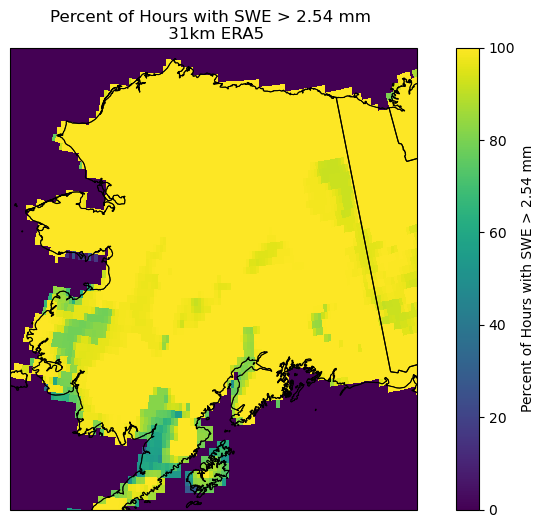

In [97]:
raw_total_hours = len(raw_SNOW)
raw_total_hours = raw_SNOW.shape[0]


RAINcriteriacount_RAW = np.sum(raw_RAIN > 0.254, axis=0)
percentRAIN_MET_RAW= (RAINcriteriacount_RAW / raw_total_hours) * 100

SFcriteriacount_RAW=np.sum(raw_SF, axis=0)
percentSF_MET_RAW= (SFcriteriacount_RAW / raw_total_hours) * 100

SNOWcriteriacount_Raw = np.sum(raw_SNOW > 2.54, axis=0)
percentSNOW_MET_RAW = (SNOWcriteriacount_Raw / raw_total_hours) * 100



AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))} 
plt.figure(figsize=(10,6))
ax = plt.axes(**AK_ALBERS_SUBPLOT_KW)
plt.pcolormesh(percentSNOW_MET_Raw['longitude'], 
               percentSNOW_MET_Raw['latitude'], 
               percentSNOW_MET_Raw, 
               shading='auto', 
               cmap='viridis',
               vmin=0,
               vmax=100,
               transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.8, edgecolor='black')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)

plt.colorbar(label='Percent of Hours with SWE > 2.54 mm', ax=ax)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Percent of Hours with SWE > 2.54 mm \n 31km ERA5')
plt.show()

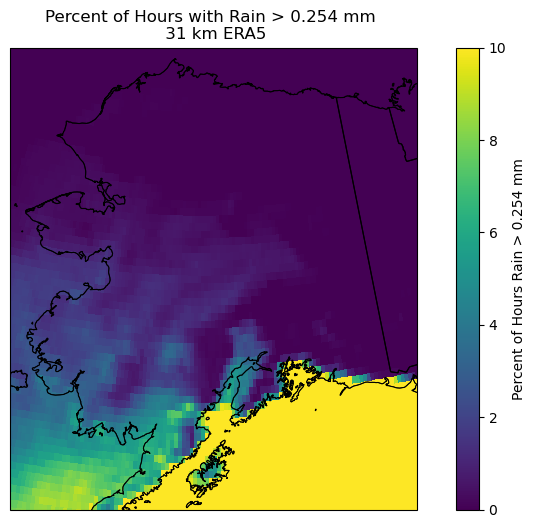

In [96]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))} 
plt.figure(figsize=(10,6))
ax = plt.axes(**AK_ALBERS_SUBPLOT_KW)

plt.pcolormesh(percentRAIN_MET_Raw['longitude'], 
               percentRAIN_MET_Raw['latitude'], 
               percentRAIN_MET_Raw, 
               shading='auto', 
               cmap='viridis',
               vmin=0,
               vmax=10,
               transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.8, edgecolor='black')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)

plt.colorbar(label='Percent of Hours Rain > 0.254 mm', ax=ax)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Percent of Hours with Rain > 0.254 mm \n 31 km ERA5')
plt.show()

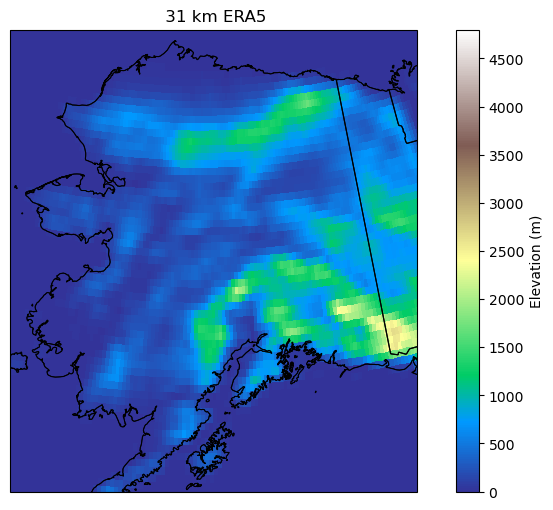

In [27]:
from pathlib import Path
fiboreal = Path(f"/import/AKCASC/")
GEOPOTENTIAL = fiboreal / "data/cds/reanalysis-era5-invariants/era5_geopotential.nc"
Re = 6367.47 * 1000 # Earth radius in m
g = 9.8067  # gravitational acceleration in m/s^2
def z_to_altitude(z):
    return (z * Re) / (g * Re - z)

with xr.load_dataset(GEOPOTENTIAL, engine="netcdf4") as ds:
    altitude31 = z_to_altitude(ds.isel(time=0).z)



AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))} 
plt.figure(figsize=(10,6))
ax = plt.axes(**AK_ALBERS_SUBPLOT_KW)
p = altitude31.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='terrain',
    vmin=0,
    vmax=4800,
    add_colorbar=False)
cbar = plt.colorbar(p, ax=ax, label='Elevation (m)', ticks=np.arange(0, 4900, 100)[::5])
#cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.8, edgecolor='black')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(' 31 km ERA5')
plt.show()

In [ ]:



AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))} 
plt.figure(figsize=(10,6))
ax = plt.axes(**AK_ALBERS_SUBPLOT_KW)
p = altitude.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='terrain',
    vmin=0,
    vmax=4800,
    add_colorbar=False)
cbar = plt.colorbar(p, ax=ax, label='Elevation (m)', ticks=np.arange(0, 4900, 100)[::5])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.8, edgecolor='black')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(' 31 km ERA5')
plt.show()